In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/altegrad

/content/drive/My Drive/altegrad


In [3]:
!pip install python-igraph

     |████████████████████████████████| 3.2MB 7.9MB/s 


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from sklearn.metrics import log_loss

from tqdm import tqdm_notebook
plt.style.use('ggplot')
from warnings import simplefilter,filterwarnings
# ignore all future warnings
filterwarnings("ignore")
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)


from src.preprocess import read_data, pre_process_text, filter_text
from src.k_core import get_k_core
from src.word2vec import Word2Vec, BagOfWords

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Setting

In [0]:
# path of files to read :
train_data = "data/train.csv"
test_data  = "data/test.csv"
texts_path = "data/text/text"
kaggle  = pd.read_csv("./data/kaggle.csv")

# vocab path for word2vec
fr_embeddings = Path('data/cc.fr.300.vec.gz')
en_embeddings = Path('data/cc.en.300.vec.gz')
import urllib.request as tr
if not en_embeddings.exists():
    tr.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings)
if not fr_embeddings.exists():
    tr.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings)

# preprocessing :
num_words = 512
do_stem = False
do_tokenize = False

# text filters
min_word_length = 4
min_text_length = 20

# k_core decomposition
do_kcore = False

# Preprocess data

In [0]:
# read data
df, test_df = read_data(train_data, test_data, texts_path)
# drop empty rows
df = df.dropna()

reading training data ...
reading test data ...
reading text files ...


100%|████████████████████████████████████████████████████████████████████████████| 28003/28003 [04:44<00:00, 98.35it/s]


finished


In [0]:
# preprocess data
tqdm.pandas()
print("Preprocessing training data...")
df["text"] = df["text"].progress_apply( lambda x : pre_process_text(x, num_words, do_stem, do_tokenize))
print("Preprocessing test data...")
test_df["text"] = test_df["text"].progress_apply( lambda x : pre_process_text(x, num_words, do_stem, do_tokenize))

Preprocessing training data...


100%|██████████████████████████████████████████████████████████████████████████████| 1994/1994 [06:37<00:00,  5.01it/s]


Preprocessing test data...


100%|████████████████████████████████████████████████████████████████████████████████| 560/560 [01:50<00:00,  5.07it/s]


In [0]:
# filtering data
tqdm.pandas()
print("Filtering training data...")
df["text"] = df["text"].progress_apply( lambda x : filter_text(x, min_word_length = 4 , min_text_length = 15,dataset = "train"))
df = df[df.text!="No text"]
df = df.reset_index(drop=True)
print("Filtering test data...")
test_df["text"] = test_df["text"].progress_apply( lambda x : filter_text(x, min_word_length = 4 , min_text_length = 0,dataset ="test"))

Filtering training data...


 24%|██████████████████▋                                                            | 471/1994 [02:20<08:03,  3.15it/s]

In [0]:
# get k core decomposition to pick most relevant words
if do_kcore:
    df = get_k_core(df)
    test_df =  get_k_core(test_df)

In [0]:
# convert labels
classes = {"business/finance":0,"education/research":1,"entertainment":2,"health/medical":3,"news/press":4, \
           "politics/government/law":5, "sports":6, "tech/science":7}
for i in range(len(df)):
    df.label[i] = classes[df.label[i]]

In [0]:
#save files
df.to_csv("./data/processed_train.csv", index=False)
test_df.to_csv("./data/processed_test.csv", index=False)

# TFIDF

In [0]:
# Load data 
df = pd.read_csv("./data/train_preprocessed.csv")
test_df = pd.read_csv("./data/test_preprocessed.csv")
df = df.dropna()
X = df.text.values
y = df.label.values

In [0]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.25, random_state=70)

In [0]:
# create tfidf vectors
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(decode_error='ignore', strip_accents='unicode', encoding='latin-1', min_df=10, max_df=1000)
X_train_tfidf = vec.fit_transform(X_train)
X_test_tfidf = vec.transform(X_test)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create logistic regression
logistic = LogisticRegression(multi_class="auto")

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = clf.fit(X_train_tfidf, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 21.544346900318832


In [10]:
from sklearn.metrics import accuracy_score, log_loss
y_pred = best_model.predict(X_test_tfidf)
print("accuracy score : ",accuracy_score(y_test, y_pred))
print("Loss :", log_loss(y_test, best_model.predict_proba(X_test_tfidf)))

accuracy score :  0.5788336933045356
Loss : 1.195474602345714


In [0]:
# Write predictions to a file
test_tfidif = vec.transform(test_df.text)
prediction_ = best_model.predict_proba(test_tfidif)
test_hosts = list(kaggle.Host.values)
import csv
with open('tfidf.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = kaggle.columns.to_list()
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = prediction_[i].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

# FastText 

In [0]:

# Installing FastText : 
"""
!rm -r fastText/
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText/
!pip install .
!cd ..
"""
#Loading weights
"""
fasttext.util.download_model('fr', if_exists='ignore') 
ft = fasttext.load_model('cc.fr.300.bin')
"""
#Load preprocessed data
"""
train = pd.read_csv('train_preprocessed.csv')
test = pd.read_csv("test_preprocessed.csv")
"""
# create train_data and test_data: 
"""
train_data = []
for x in train.dropna().text:
    train_data.append(ft.get_sentence_vector(x,))
test_data = []
for x in test.dropna().text:
    test_data.append(ft.get_sentence_vector(x,))
train_data = np.array(train_data)
test_data = np.array(test_data)
y_train  = transform_one_hot(  train.dropna().label.values)
"""
#save weights 
"""
np.save("train_data_fasttext.npy",train_data)
np.save("train_labels_fastext.npy",y_train)
np.save("test_data_fasttext.npy",test_data)
"""
#Load weights : 
train_data = np.load("saved_files/train_data_fasttext.npy")
y_train = np.load("saved_files/train_labels_fastext.npy")
test_data = np.load("saved_files/test_data_fasttext.npy")


In [13]:
print("The shape of train data is "+str(np.shape(train_data)))
print("The shape of train data labels is "+str(np.shape(y_train)))
print("The shape of test data is "+str(np.shape(test_data)))


The shape of train data is (1849, 300)
The shape of train data labels is (1849, 8)
The shape of test data is (560, 300)


In [14]:
#Creating neural network 
r,c = train_data.shape
modelfastText = Sequential()
modelfastText.add(Conv1D(128, 4, activation='relu', padding='valid',input_shape=(c,1)))
modelfastText.add(Dropout(0.5))
modelfastText.add(Flatten())
modelfastText.add(Dense(8, activation='softmax'))  #multi-label (k-hot encoding)
modelfastText.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 297, 128)          640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 297, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38016)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 304136    
Total params: 304,776
Trainable params: 304,776
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Splitting data into training and validation 
X_tra, X_val, y_tra, y_val = train_test_split(train_data.reshape(r,c,1),y_train , train_size=0.85)
#train a single  model
earlyStopping = EarlyStopping(monitor='val_loss', patience=50,min_delta=1e-5,restore_best_weights=True ,verbose=2, mode='min')
modelfastText.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['categorical_accuracy'])
    
hist = modelfastText.fit(X_tra, y_tra, batch_size=2048, epochs=600, validation_data=(X_val, y_val),callbacks=[earlyStopping],verbose=2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1571 samples, validate on 278 samples
Epoch 1/600





 - 13s - loss: 2.0786 - categorical_accuracy: 0.2342 - val_loss: 2.0450 - val_categorical_accuracy: 0.3022
Epoch 2/600
 - 0s - loss: 2.0478 - categorical_accuracy: 0.2743 - val_loss: 1.9980 - val_categorical_accuracy: 0.3022
Epoch 3/600
 - 0s - loss: 2.0046 - categorical_accuracy: 0.2763 - val_loss: 1.9335 - val_categorical_accuracy: 0.3022
Epoch 4/600
 - 0s - loss: 1.9462 - categorical_accuracy: 0.2928 - val_loss: 1.8580 - val_categorical_accuracy: 0.3022
Epoch 5/600
 - 0s - loss: 1.8797 - categorical_accuracy: 0.2890 - val_loss: 1.7886 - val_categorical_accuracy: 0.3201
Epoch 6/600
 - 0s - loss: 1.8218 - categorical_accuracy: 0.3081 - val_loss: 1.7502 - val_categorical_accuracy: 0.3741
Epoch 7/600
 - 0s - loss: 1.7983 - categorical_accuracy: 0.3361 - val_loss: 1.7514 - val_categorical_accuracy: 0.2950
Epoch 8/600
 - 0s - lo

In [16]:
print("validation loss of best epoch")
print(  log_loss(y_val, modelfastText.predict_proba(X_val) ))

validation loss of best epoch
1.0491794188131691


In [17]:
#blending multiple FastText models to predict test labels
n = 20
preds = []
earlyStopping = EarlyStopping(monitor='val_loss', patience=100,min_delta=1e-5,restore_best_weights=True ,verbose=0, mode='min')

for i in tqdm_notebook(range(n)):
    model = Sequential()
    m = np.random.choice([64,32,50,100,20,300])
    
    model.add(Conv1D(m, 4, activation='relu', padding='valid',input_shape=(300,1)))
    drop = np.random.choice([0.2,0.4,0.6])
    model.add(Dropout(drop))
    model.add(Flatten())
   
    model.add(Dense(8, activation='softmax'))  #multi-label (k-hot encoding)
    
    


    
    X_tra, X_val, y_tra, y_val = train_test_split(train_data.reshape(1849,300,1),y_train , train_size=0.80)
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['categorical_accuracy'])


    
    hist = model.fit(X_tra, y_tra, batch_size=1024, epochs=600, validation_data=(X_val, y_val),callbacks=[earlyStopping],verbose=0)
    y_test = model.predict_proba(np.array(test_data).reshape(560,300,1)) 
    
    preds.append(y_test)


In [18]:
#predicting test labels : 
fasttext_df = pd.read_csv("saved_files/graph_baseline.csv")
y_test = np.mean(preds,axis=0)
fasttext_df.loc[:,fasttext_df.columns[1:]] = y_test
fasttext_df.head(10)


,Host,business/finance,education/research,entertainment,health/medical,news/press,politics/government/law,sports,tech/science
0,27997,0.180167,0.457875,0.222623,0.000149,0.028417,0.019923,0.025170,0.065675
1,9316,0.233947,0.016154,0.568829,0.000108,0.076303,0.001297,0.053943,0.049419
2,27045,0.621927,0.002541,0.338860,0.007097,0.018335,0.000577,0.005273,0.005391
3,19805,0.038542,0.021738,0.008269,0.895884,0.004803,0.020098,0.001076,0.009590
4,26580,0.061945,0.287197,0.189942,0.020335,0.096425,0.119118,0.003975,0.221063
5,16886,0.074311,0.010211,0.815029,0.005123,0.050438,0.008206,0.011435,0.025248
6,27931,0.163313,0.010612,0.745544,0.001582,0.038148,0.027122,0.009809,0.003871
7,8977,0.153492,0.294532,0.269260,0.082540,0.027831,0.039561,0.010942,0.121842
8,20285,0.005407,0.015207,0.083071,0.000776,0.013367,0.011486,0.867571,0.003115
9,2427,0.116083,0.433328,0.190309,0.011710,0.025405,0.097031,0.006869,0.119264


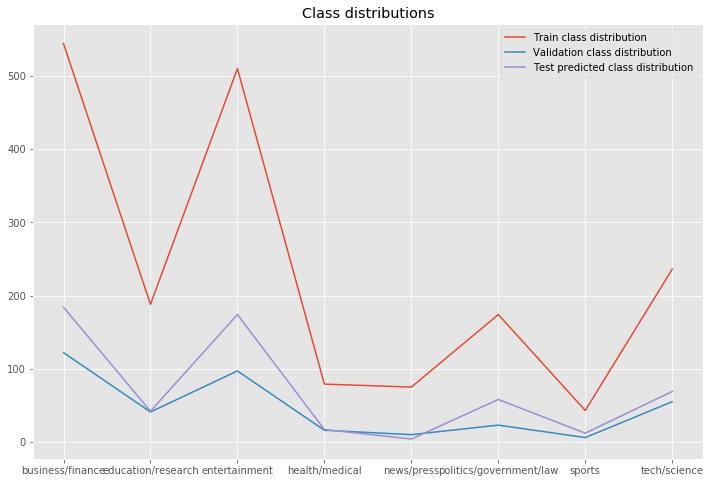

In [19]:
#class distribution
plt.figure(figsize=(12,8))

plt.title("Class distributions")

plt.plot(  fasttext_df.columns[1:] , np.bincount(np.argmax(y_train,axis=1)) ,label="Train class distribution"  )

plt.plot(  fasttext_df.columns[1:] , np.bincount(np.argmax(y_val,axis=1)) ,label="Validation class distribution" )


plt.plot(  fasttext_df.columns[1:] , np.bincount(np.argmax(y_test,axis=1)) , label= "Test predicted class distribution" )

plt.legend()
plt.show()

In [20]:
#postprocessing 
test2 = pd.read_csv("saved_files/test_fr.csv")
k ,a= 0,[]
for t in list(test2.text):
    if len(str(t).split())<2:
        a.append(k)        
    k+=1
print("the number of empty websites is "+str(len(a))) 


the number of empty websites is 30


In [21]:
#compute Class frequency vector
frequency_vector = np.bincount(np.argmax(y_train,axis=1))/np.sum(np.bincount(np.argmax(y_train,axis=1)))
frequency_vector

array([0.29421309, 0.10167658, 0.27582477, 0.0427258 , 0.04056247,
       0.09410492, 0.02325581, 0.12763656])

In [22]:
#Replace the empty websites predictions with frequency vector
fasttext_df.loc[a,fasttext_df.columns[1:]] = frequency_vector
fasttext_df.iloc[a][:5]


,Host,business/finance,education/research,entertainment,health/medical,news/press,politics/government/law,sports,tech/science
17,18965,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
24,12970,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
51,8759,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
91,26547,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
99,19524,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637


In [0]:
fasttext_df.to_csv("fastText_df.csv",index=False)

# Word2Vec

In [0]:
# Load data 
df = pd.read_csv("./data/train_preprocessed.csv")
test_df = pd.read_csv("./data/test_preprocessed.csv")
df = df.dropna()
X = df.text.values
y = df.label.values
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.25, random_state=70)

In [0]:
w2v = Word2Vec(fr_embeddings, vocab_size=50000)
sentence2vec = BagOfWords(w2v)

# encode data with sentence2vec
X_train_encode = [sentence2vec.encode(X_train[i]).tolist() for i in range(len(X_train))]
X_test_encode = [sentence2vec.encode(X_test[i]).tolist() for i in range(len(X_test))]

Loaded 50000 pretrained word vectors


In [0]:
# Create logistic regression
logistic = LogisticRegression(multi_class="auto")

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = clf.fit(X_train_encode, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

In [0]:
y_pred = best_model.predict(X_test_encode)
print("accuracy score : ",accuracy_score(y_test, y_pred))
print("Loss :", log_loss(y_test, best_model.predict_proba(X_test_encode)))

# Bert, XLM

In [24]:
!pip install transformers

     |████████████████████████████████| 501kB 7.0MB/s 
     |████████████████████████████████| 1.0MB 38.7MB/s 
     |████████████████████████████████| 870kB 39.0MB/s 
     |████████████████████████████████| 3.7MB 38.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=d8fa359b31500290b2c48b3f2b2592d621fab139078fde21c85ccd483d5895f0
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# Load data 
df = pd.read_csv("./data/train_preprocessed.csv")
test_df = pd.read_csv("./data/test_preprocessed.csv")
X = df.text.values
y = df.label.values

In [0]:
train_sentences = list(X)
train_label = y

In [0]:
train_sentences = [str(sentence) for sentence in train_sentences]

In [0]:
train_label = train_label.astype(np.int64)

In [0]:
# set device to use GPU
import torch
device = torch.device("cuda")

# Models
models = ["Bert", "XLM"]
model = "Bert"

# params
MAX_LEN = 140
batch_size = 16
epochs = 4
lr = 1e-5

In [30]:
from transformers import BertTokenizer, XLMTokenizer

# Load the model tokenizer.
print('Loading  tokenizer...')
if model == "Bert":
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
if model == "XLM":
    tokenizer = XLMTokenizer.from_pretrained('xlm-clm-enfr-1024', do_lower_case=True)



# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in tqdm(train_sentences):
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Truncate all sentences.)
    )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)


Loading  tokenizer...


  0%|          | 0/1849 [00:00<?, ?it/s]

100%|██████████| 1849/1849 [00:42<00:00, 28.16it/s]


In [0]:
#`pad_sequences` utility .
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [32]:
# Create attention masks
print("Creating attention masks")
attention_masks = []
from tqdm import tqdm
# For each sentence...
for sent in tqdm(input_ids):
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

100%|██████████| 1849/1849 [00:00<00:00, 10377.79it/s]

Creating attention masks


In [0]:
# Use train_test_split to split our data into train and validation sets for
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_label, 
                                                            random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, train_label,
                                             random_state=2018, test_size=0.2)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [36]:
from transformers import BertForSequenceClassification, XLMForSequenceClassification, DistilBertForSequenceClassification

if model == "Bert":
    model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels = 8, output_attentions = False, output_hidden_states = False)
if model == "XLM":
    model = XLMForSequenceClassification.from_pretrained('xlm-clm-enfr-1024', num_labels = 8, output_attentions = False, output_hidden_states = False)



# Tell pytorch to run this model on the GPU.
model.cuda()
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

In [0]:
from torch import optim
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [0]:
from transformers import get_linear_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


#get_linear_schedule_with_warmup

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #print(np.shape(preds))
    #print(preds)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [40]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        #scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               loss validation
    # ========================================

    # Reset the total loss for this epoch.
    total_loss = 0
    model.eval()

    # For each batch of training data...
    for step, batch in enumerate(validation_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(validation_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average validation loss: {0:.2f}".format(avg_train_loss))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:34.
  Batch    80  of     93.    Elapsed: 0:01:07.

  Average training loss: 1.77
  Training epcoh took: 0:01:18

  Average validation loss: 1.42

Running Validation...
  Accuracy: 0.51
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:34.
  Batch    80  of     93.    Elapsed: 0:01:07.

  Average training loss: 1.47
  Training epcoh took: 0:01:18

  Average validation loss: 1.21

Running Validation...
  Accuracy: 0.59
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:34.
  Batch    80  of     93.    Elapsed: 0:01:07.

  Average training loss: 1.25
  Training epcoh took: 0:01:18

  Average validation loss: 1.17

Running Validation...
  Accuracy: 0.57
  Validation took: 0:00:06

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:34.
  Batch    80

In [0]:
torch.save(model, './models/Bert_last')

Bert : loss 1.20, acc 0.57 epoch 7, 100 words

Bert  no warmup : loss 1.15, acc 0.65, epoch 3, 100 words, lr = 1.e-5

XLM with clm, loss 1.32, acc 0.59 epoch 5 , 100 words

Bert  cosine warmup : loss 1.08, acc 0.62, epoch 4, 100 words, lr = 1.e-5


# Inference

In [42]:
import pandas as pd


# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df.text.values
labels = np.zeros(test_df.shape[0])

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True,
                        max_length = 512,  # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)


# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 560



In [43]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

Predicting labels for 560 test sentences...
DONE.


In [0]:
from scipy.special import softmax
def get_probs(vect):
    res = []
    #n,c = np.shape(vect)
    for batch in vect:
        for v in batch : 
            res.append(softmax(v))
    return res

In [0]:
# Write predictions to a file
prediction_ = get_probs(predictions)
test_hosts = list(kaggle.Host.values)
import csv
with open('Bert07.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = kaggle.columns.to_list()
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = prediction_[i].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

In [0]:
#final model

tfidf = pd.read_csv("tfidf.csv")
bert = pd.read_csv("Bert07.csv")
fasttext = pd.read_csv("fastText_df.csv")

final_pred = tfidf.copy()
final_pred.loc[:,final_pred.columns[1:]] = 0.25 * bert.loc[:,bert.columns[1:]] + 0.7*fasttext.loc[:,fasttext.columns[1:]] + 0.05 *tfidf.loc[:,tfidf.columns[1:]]

In [0]:
#Replace the empty websites predictions with frequency vector
#final_pred.loc[a,final_pred.columns[1:]] = frequency_vector

In [53]:
#final_pred.iloc[a]

,Host,business/finance,education/research,entertainment,health/medical,news/press,politics/government/law,sports,tech/science
17,18965,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
24,12970,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
51,8759,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
91,26547,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
99,19524,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
111,10861,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
114,18155,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
135,15151,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
139,13560,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637
146,19885,0.294213,0.101677,0.275825,0.042726,0.040562,0.094105,0.023256,0.127637


In [57]:
final_pred.head()

,Host,business/finance,education/research,entertainment,health/medical,news/press,politics/government/law,sports,tech/science
0,27997,0.149249,0.495470,0.193233,0.009428,0.027103,0.029247,0.022248,0.074022
1,9316,0.221549,0.018925,0.602724,0.003235,0.063607,0.003240,0.043145,0.043575
2,27045,0.650820,0.004086,0.298257,0.009769,0.018679,0.002360,0.009390,0.006639
3,19805,0.050291,0.032108,0.014941,0.840549,0.011753,0.023314,0.010395,0.016649
4,26580,0.059731,0.333517,0.186301,0.024385,0.082237,0.118392,0.007928,0.187509


In [0]:
final_pred.to_csv("final_pred.csv",index=False)